In [1]:
!pip install cur

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.utils.extmath import randomized_svd
from tqdm.notebook import tqdm
from cur import cur
import warnings
warnings.filterwarnings('ignore')

# Stochastic CUR

In [3]:
#%%writefile CUR.py
import numpy as np
import pandas as pd
from sklearn.utils.extmath import randomized_svd

class CUR():
    def __init__(self, k, eps, it=None, truncated=False):
        self.k = k
        self.eps = eps
        self.trunc = truncated
        self.c = k * np.log(k) / eps**2 #expectation number of sampled columns
        self.C, self.U, self.R = None, None, None #matrices of decomposition
        self.pi_col, self.pi_row = None, None #leverage scores of corresponding columns/rows
        self.col_indices = None
        self.row_indices = None

    def column_select(self, A):
        n = A.shape[1]
        A = np.array(A.copy())
        if self.trunc:
            _, _, v_k = randomized_svd(A, self.k) #for very big matrices
        else:
            _, _, vh = np.linalg.svd(A, full_matrices=False)
            v_k = vh[0:self.k, :]

        pi = 1 / self.k * np.sum(v_k**2, axis=0)
        c_index = [np.random.choice(2,
                        p=[1 - min(1, self.c * pi[i]), min(1, self.c * pi[i])]) for i in range(n)
                  ]
        c_index = np.nonzero(c_index)[0]

        C = A[:, c_index]
        return C, c_index, pi

    def run_CUR(self, A):
        A = np.array(A.copy())
        self.C, self.col_indices, self.pi_col = self.column_select(A)
        self.R, self.row_indices, self.pi_row = self.column_select(A.T)
        self.U = np.linalg.pinv(self.C) @ A @ np.linalg.pinv(self.R.T)
        return self.C, self.U, self.R.T

## Functional representation

## First try

In [4]:
A = np.random.randn(10,8)

In [5]:
cur = CUR(k=2, eps=0.5,)

In [6]:
C,U,R = cur.run_CUR(A)
print(C.shape, U.shape, R.shape)

(10, 4) (4, 6) (6, 8)


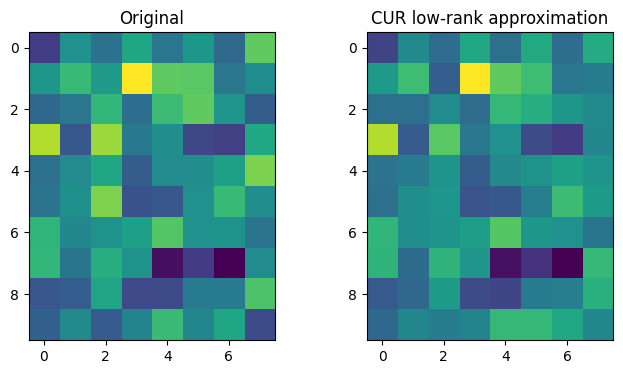

In [7]:
plt.figure(figsize=(8,4))

plt.subplot(121)
plt.imshow(A)
plt.title('Original')

plt.subplot(122)
plt.imshow(C@U@R)
plt.title('CUR low-rank approximation')

plt.show()

# Kidney & Colon gene expression data

The data is taken from [OpenML project](https://www.openml.org/d/1137).

In [8]:
df = pd.read_csv('https://raw.githubusercontent.com/palles77/DataPreprocessing/main/AP_Colon_Kidney.csv', index_col=0)

In [9]:
df.head()

,1007_s_at,121_at,1405_i_at,1438_at,1487_at,1494_f_at,1552256_a_at,1552257_a_at,1552274_at,1552275_s_at,...,AFFX-r2-Ec-bioC-3_at,AFFX-r2-Ec-bioC-5_at,AFFX-r2-Ec-bioD-3_at,AFFX-r2-Ec-bioD-5_at,AFFX-r2-P1-cre-3_at,AFFX-r2-P1-cre-5_at,AFFX-ThrX-3_at,AFFX-ThrX-5_at,AFFX-ThrX-M_at,Tissue
ID_REF,,,,,,,,,,,,,,,,,,,,,
203679,2883.2,2109.1,702.0,114.4,822.2,235.1,3346.1,815.1,233.3,218.4,...,2035.7,1908.1,30396.7,28371.7,85830.1,57084.9,3651.2,1736.1,2411.6,Kidney
179949,2607.4,1204.2,228.0,19.2,1497.1,167.6,23003.6,948.6,414.1,124.1,...,3811.6,3012.0,16748.8,13581.2,53322.5,37139.5,1648.1,502.9,890.6,Kidney
76558,2736.8,3912.2,1020.8,39.0,574.9,448.9,1337.9,605.6,176.8,411.9,...,17154.4,14835.5,64597.8,59311.2,203060.6,146422.6,3346.4,673.2,1499.3,Kidney
203712,1471.6,1318.2,4564.6,9.4,1426.5,105.2,2594.3,929.8,240.4,139.0,...,12382.2,11300.8,58551.7,49073.6,119460.8,95682.3,2553.5,961.2,1468.4,Kidney
102522,3564.7,2535.6,944.1,40.0,734.2,651.0,1490.5,712.3,632.7,185.0,...,13321.1,12966.9,54572.5,51049.1,178178.2,129533.2,3399.1,1209.8,1981.6,Kidney


In [10]:
X, y = df.drop('Tissue', axis=1), df['Tissue']
Xlog = np.log10(X + 1.0) #log expression data is more convenient to work

Below we compare a case of data dimensionality reduction with both CUR and SVD algorithms.

## SVD

In [11]:
X_log_centered = Xlog - Xlog.mean(0)
u,s,v = np.linalg.svd(X_log_centered)

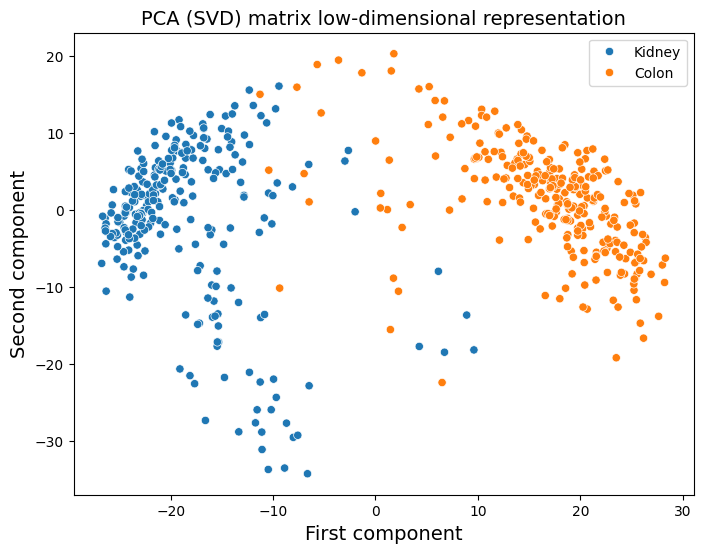

In [12]:
k=2
X_svd = (u@np.diag(s))[:,:k]

fig, ax = plt.subplots(figsize=(8,6))

sns.scatterplot(x=X_svd[:,0], y=X_svd[:,1], hue=y, ax=ax)
plt.title('PCA (SVD) matrix low-dimensional representation', fontsize=14)
plt.xlabel('First component', fontsize=14)
plt.ylabel('Second component', fontsize=14)
ax.legend()


plt.show()

## CUR

CUR return a random number of vectors for given $\epsilon$ and $k$ parameters. Therefore it may require several runs to return a definite number of column vectors of matrix $C$ (or $R$).

In [13]:
cur = CUR(2, 0.5, truncated=False)
C,U,R = cur.run_CUR(Xlog)
C.shape

(546, 7)

In [14]:
ids = np.argsort(cur.pi_col)[::-1][:5]
ids #top 5 genes by leverage score

array([4111, 9992, 3238, 1481, 2728])

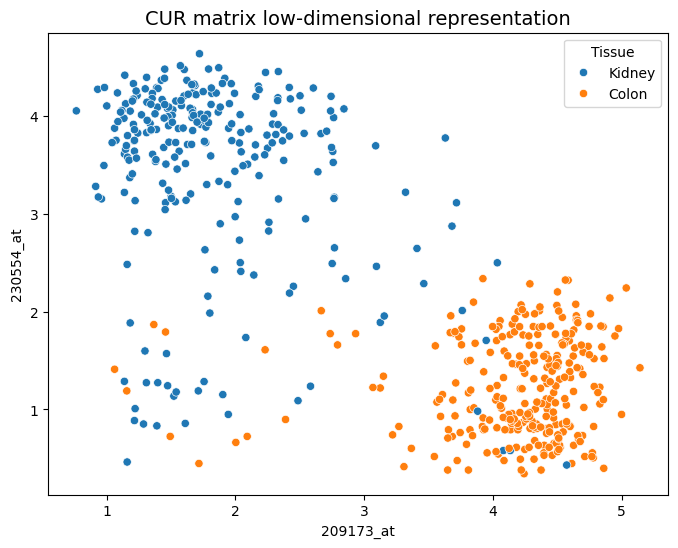

In [15]:
#plot 2 of them
fig, ax = plt.subplots(figsize=(8,6))
x1 = Xlog.iloc[:, ids[0]]
x2 = Xlog.iloc[:, ids[1]]
sns.scatterplot(x=x1, y=x2, hue=y, ax=ax)
plt.title('CUR matrix low-dimensional representation', fontsize=14)
plt.xlabel(x1.name)
plt.ylabel(x2.name)

plt.show()

In [16]:
#construct projection of data matrix on the space of selected columns
X_proj = C@np.linalg.pinv(C)@Xlog

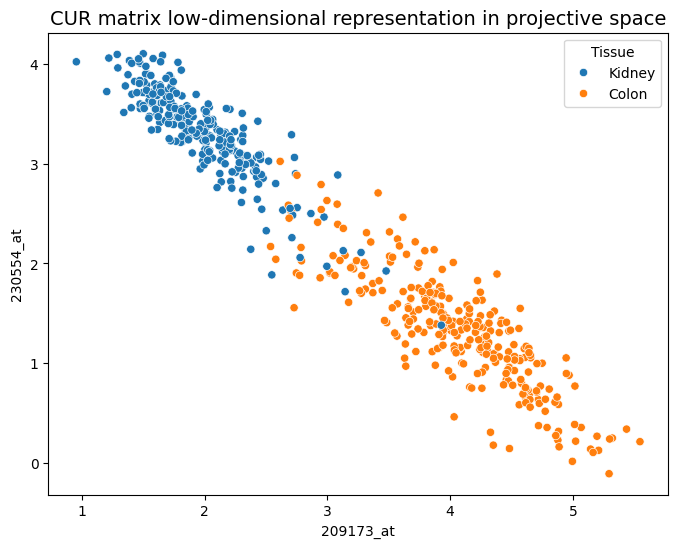

In [17]:
#plot 2 of them
fig, ax = plt.subplots(figsize=(8,6))
x1 = X_proj.iloc[:, ids[0]]
x2 = X_proj.iloc[:, ids[1]]
sns.scatterplot(x=np.array(x1), y=np.array(x2), hue=y, ax=ax)
plt.title('CUR matrix low-dimensional representation in projective space', fontsize=14)
plt.xlabel(x1.name)
plt.ylabel(x2.name)

plt.show()

In [18]:
import pandas as pd
import numpy as np

# Load the full dataset without setting an index
car_prices_df = pd.read_csv('https://gist.githubusercontent.com/palles77/38bd063939c1ac08b8d1e4f7c2c26abc/raw/b01ca987613684082b3897dd24e2f00909da6bd9/car_prices.csv')

# Drop specified columns
car_prices_df = car_prices_df.drop(['ID', 'Price', 'Doors'], axis=1)

# Replace '-' with '0' in the 'Levy' column
car_prices_df['Levy'] = car_prices_df['Levy'].replace('-', '0')
# Convert 'Levy' to an integer
car_prices_df['Levy'] = car_prices_df['Levy'].astype(int)

# Remove ' km' suffix from 'Mileage' and convert to integer
car_prices_df['Mileage'] = car_prices_df['Mileage'].str.replace(' km', '').astype(int)

# Convert the DataFrame to a NumPy array (excluding the header)
data_array = car_prices_df.to_numpy()

# Use the column names from the modified DataFrame
new_column_names = car_prices_df.columns

# Create a new DataFrame from the modified array
new_car_prices_df = pd.DataFrame(data_array, columns=new_column_names)

# Display the first 5 rows of the new DataFrame to verify
new_car_prices_df[0:5]

,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Wheel,Color,Airbags
0,1399,LEXUS,RX 450,2010,Jeep,Yes,Hybrid,3.5,186005,6.0,Automatic,4x4,Left wheel,Silver,12
1,1018,CHEVROLET,Equinox,2011,Jeep,No,Petrol,3,192000,6.0,Tiptronic,4x4,Left wheel,Black,8
2,0,HONDA,FIT,2006,Hatchback,No,Petrol,1.3,200000,4.0,Variator,Front,Right-hand drive,Black,2
3,862,FORD,Escape,2011,Jeep,Yes,Hybrid,2.5,168966,4.0,Automatic,4x4,Left wheel,White,0
4,446,HONDA,FIT,2014,Hatchback,Yes,Petrol,1.3,91901,4.0,Automatic,Front,Left wheel,Silver,4


In [19]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Assuming 'new_car_prices_df' is your DataFrame loaded correctly
df = new_car_prices_df  # Using the DataFrame from your last manipulation

# Identify categorical columns - Example columns might include 'Color', 'Gear box type'
categorical_columns = ['Leather interior', 'Manufacturer', 'Model', 'Category', 'Fuel type', 'Gear box type', 'Drive wheels', 'Wheel', 'Color']

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Apply label encoding to each categorical column after filling missing values with 'Missing'
for column in categorical_columns:
    df[column] = df[column].fillna('Missing')  # Fill missing values
    df[column] = label_encoder.fit_transform(df[column])

# After encoding, check for any NaN values across the DataFrame and replace them with zero
df.fillna(0, inplace=True)

# Optionally, ensure all numeric columns are of a numeric type (int or float)
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = pd.to_numeric(df[col], errors='coerce')
df.fillna(0, inplace=True)  # Replace any remaining NaNs that resulted from coercion errors with zero

# Display the first 5 rows of the DataFrame to verify the changes
print(df.head())

   Levy  Manufacturer  Model  Prod. year  Category  Leather interior  \
0  1399            32   1242        2010         4                 1   
1  1018             8    658        2011         4                 0   
2     0            21    684        2006         3                 0   
3   862            16    661        2011         4                 1   
4   446            21    684        2014         3                 1   

   Fuel type  Engine volume  Mileage  Cylinders  Gear box type  Drive wheels  \
0          2            3.5   186005        6.0              0             0   
1          5            3.0   192000        6.0              2             0   
2          5            1.3   200000        4.0              3             1   
3          2            2.5   168966        4.0              0             0   
4          5            1.3    91901        4.0              0             1   

   Wheel  Color  Airbags  
0      0     12       12  
1      0      1        8  
2    

In [29]:
import numpy as np
import pandas as pd

# Assuming `df` is your preprocessed DataFrame ready for CUR application

def cur_decomposition(A, k):
    # Step 1: Compute probabilities
    row_squared_norms = np.linalg.norm(A, axis=1)**2
    col_squared_norms = np.linalg.norm(A, axis=0)**2
    row_probs = row_squared_norms / row_squared_norms.sum()
    col_probs = col_squared_norms / col_squared_norms.sum()

    # Step 2: Randomly select k columns and rows based on their probabilities
    cols = np.random.choice(a=np.arange(A.shape[1]), size=k, replace=False, p=col_probs)
    rows = np.random.choice(a=np.arange(A.shape[0]), size=k, replace=False, p=row_probs)

    # Step 3: Construct matrices C, U, and R
    C = A[:, cols]
    R = A[rows, :]
    U = np.linalg.pinv(C) @ A @ np.linalg.pinv(R)

    return C, U, R

# Convert DataFrame to numpy array for processing
data_matrix = df.to_numpy()

# Apply CUR decomposition
num_features = 5  # For example, let's reduce to 10 features
C, U, R = cur_decomposition(data_matrix, num_features)

# You can use the matrix C (and R) directly as the reduced feature set
# If you want to revert back to a DataFrame for further analysis or use in ML models:
reduced_df = pd.DataFrame(C, columns=[f"Feature_{i}" for i in range(C.shape[1])])

reduced_df[0:5]


,Feature_0,Feature_1,Feature_2,Feature_3,Feature_4
0,186005.0,2010.0,1399.0,1242.0,32.0
1,192000.0,2011.0,1018.0,658.0,8.0
2,200000.0,2006.0,0.0,684.0,21.0
3,168966.0,2011.0,862.0,661.0,16.0
4,91901.0,2014.0,446.0,684.0,21.0


In [27]:
# from sklearn.decomposition import TruncatedSVD
# data_matrix = df.to_numpy()

# svd = TruncatedSVD(n_components=2)

# reduced_data = svd.fit_transform(data_matrix)

# reduced_df = pd.DataFrame(reduced_data, columns=['Component_1', 'Component_2'])

# print(reduced_df.head())

     Component_1  Component_2
0  186005.003474  2648.604369
1  192000.003123  2310.827450
2  200000.002959  2017.750061
3  168966.003098  2266.339149
4   91901.003044  2155.900143


     Component_1  Component_2  Component_3  Component_4  Component_5
0  186005.003474  2648.604369   622.186162   371.057223     0.986507
1  192000.003123  2310.827450   371.056902  -184.834250   -24.509488
2  200000.002959  2017.750061  -602.830692  -237.144998   -13.553177
3  168966.003098  2266.339149   221.769582  -194.101088   -17.015526
4   91901.003044  2155.900143  -179.776892  -206.488994   -12.674643


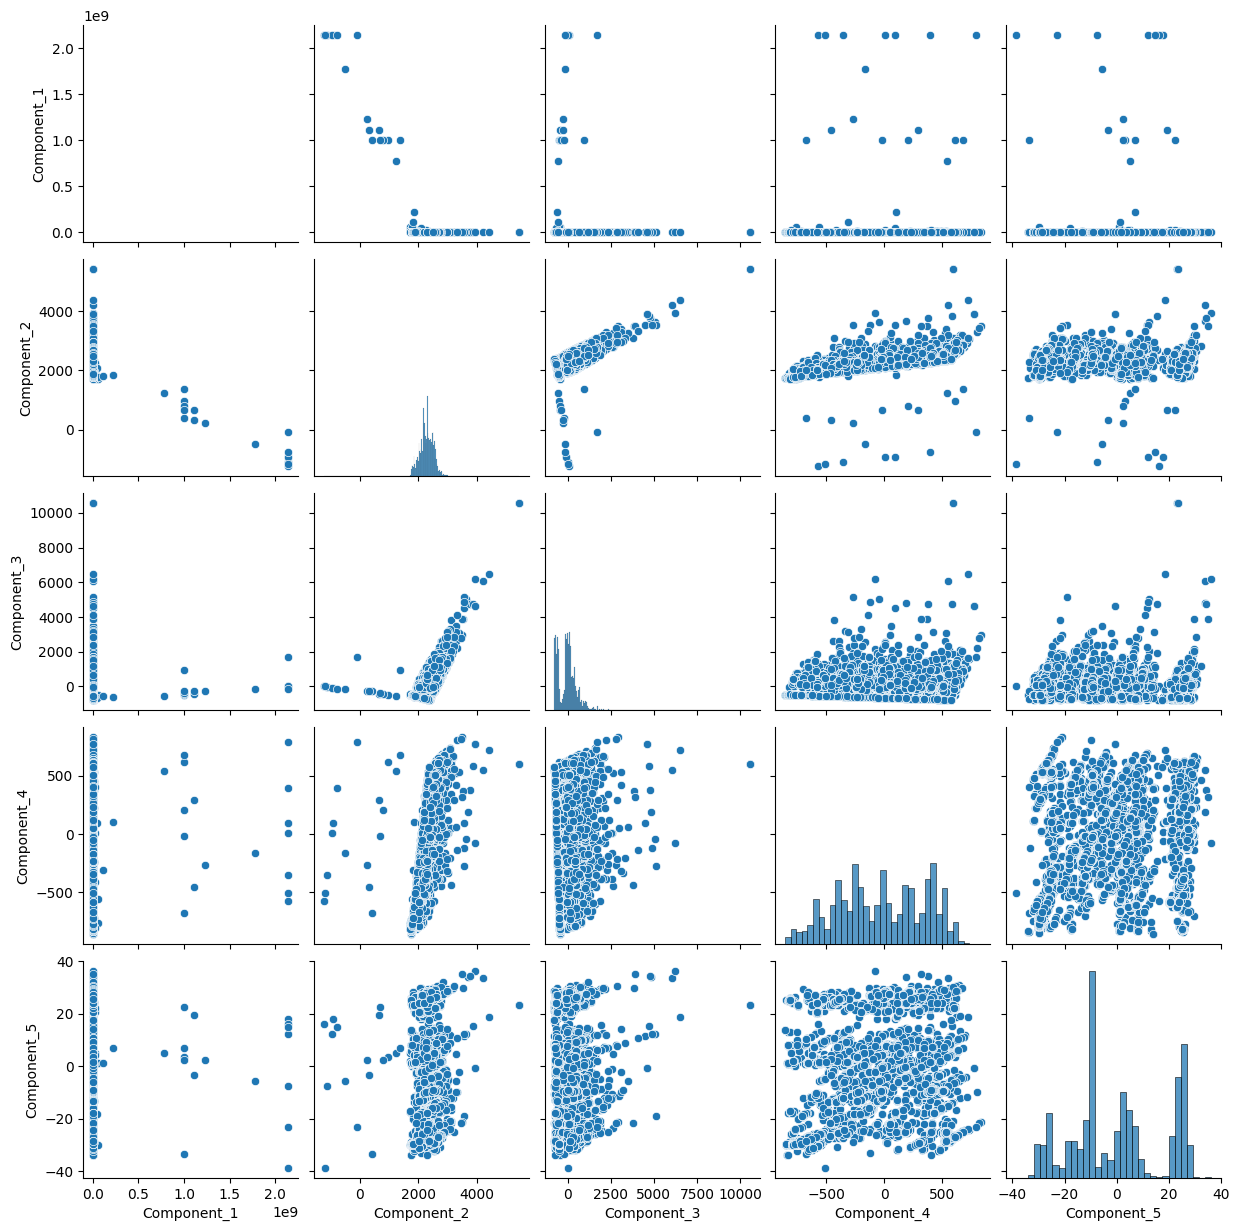

In [37]:
from sklearn.decomposition import TruncatedSVD
import seaborn as sns


svd = TruncatedSVD(n_components=5)
reduced_data = svd.fit_transform(df)
reduced_df = pd.DataFrame(reduced_data, columns=['Component_1', 'Component_2', 'Component_3', 'Component_4', 'Component_5'])

print(reduced_df.head())

sns.pairplot(reduced_df)


Dla k = 3, Silhouette Score: 0.9997
Dla k = 4, Silhouette Score: 0.9997
Dla k = 5, Silhouette Score: 0.9996
Dla k = 6, Silhouette Score: 0.9996
Dla k = 7, Silhouette Score: 0.9990
Dla k = 8, Silhouette Score: 0.9990
Dla k = 9, Silhouette Score: 0.9976
Dla k = 10, Silhouette Score: 0.9970


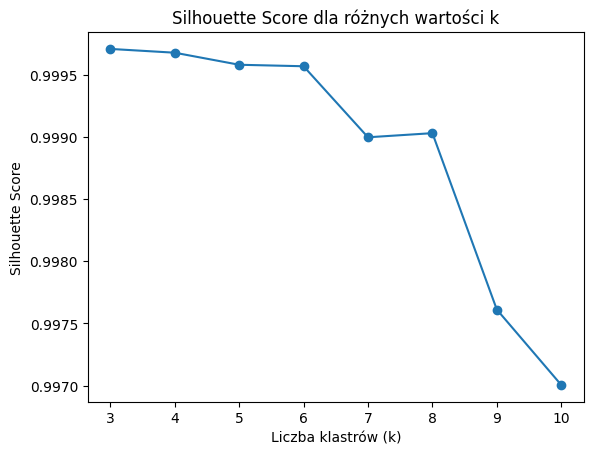

In [38]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt


k_range = range(3, 11)

silhouette_scores = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)

    kmeans.fit(reduced_df)

    score = silhouette_score(reduced_df, kmeans.labels_)
    silhouette_scores.append(score)

    print(f"Dla k = {k}, Silhouette Score: {score:.4f}")

plt.plot(k_range, silhouette_scores, marker='o')
plt.xlabel('Liczba klastrów (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score dla różnych wartości k')
plt.show()

Dla k = 3, Silhouette Score: 0.9997
Dla k = 4, Silhouette Score: 0.9997
Dla k = 5, Silhouette Score: 0.9996
Dla k = 6, Silhouette Score: 0.9996
Dla k = 7, Silhouette Score: 0.9990
Dla k = 8, Silhouette Score: 0.9990
Dla k = 9, Silhouette Score: 0.9976
Dla k = 10, Silhouette Score: 0.9970


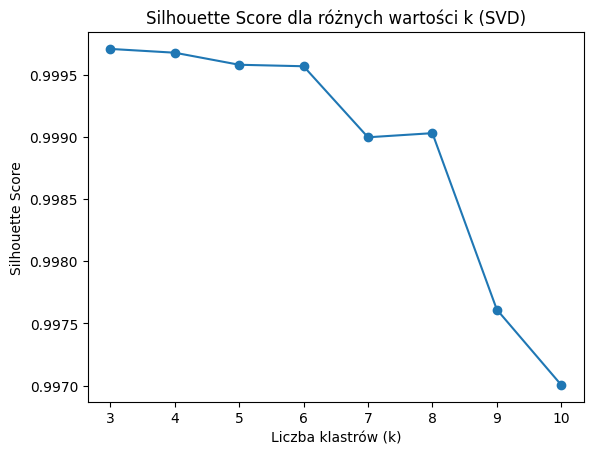

In [39]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt


k_range = range(3, 11)

silhouette_scores = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(reduced_df)
    score = silhouette_score(reduced_df, kmeans.labels_)
    silhouette_scores.append(score)

    print(f"Dla k = {k}, Silhouette Score: {score:.4f}")

plt.plot(k_range, silhouette_scores, marker='o')
plt.xlabel('Liczba klastrów (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score dla różnych wartości k (SVD)')
plt.show()

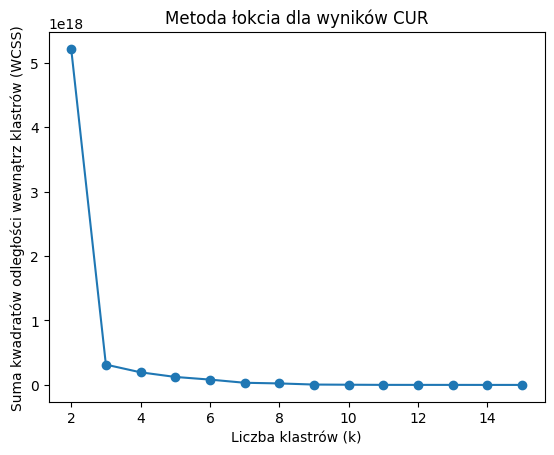

In [41]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

k_range = range(2, 16)

wcss = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)

    kmeans.fit(reduced_df)

    wcss.append(kmeans.inertia_)

plt.plot(k_range, wcss, marker='o')
plt.xlabel('Liczba klastrów (k)')
plt.ylabel('Suma kwadratów odległości wewnątrz klastrów (WCSS)')
plt.title('Metoda łokcia dla wyników CUR')
plt.show()

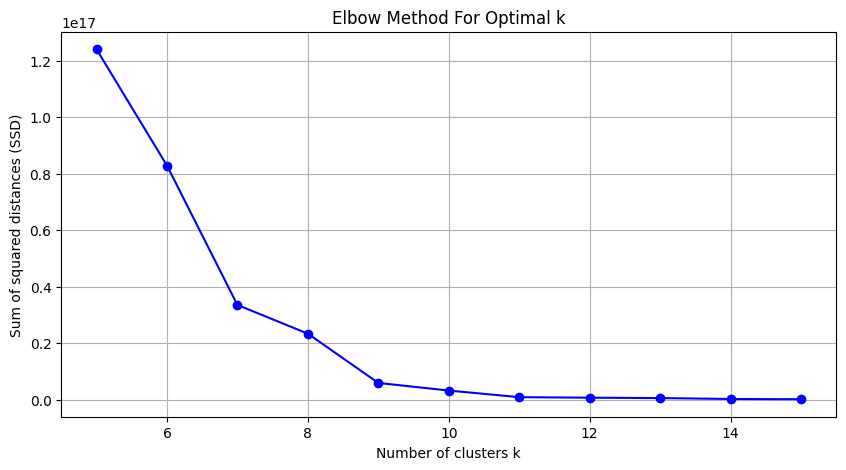

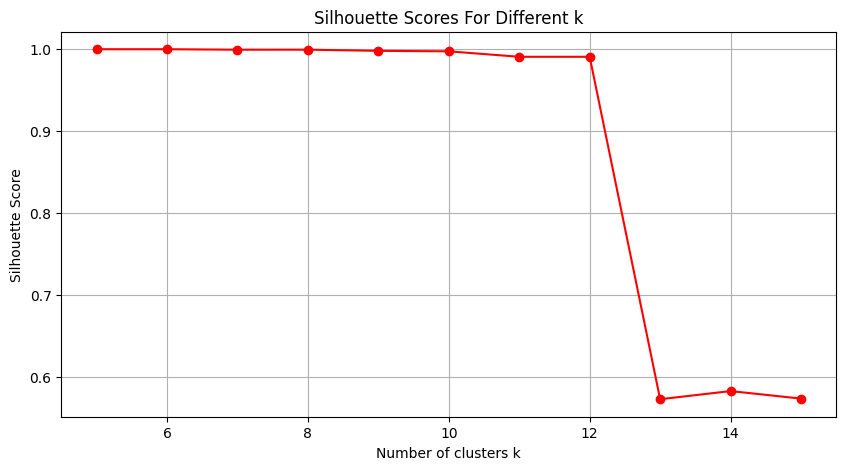

Silhouette Score for k=5: 0.9996
Silhouette Score for k=6: 0.9996
Silhouette Score for k=7: 0.9990
Silhouette Score for k=8: 0.9990
Silhouette Score for k=9: 0.9976
Silhouette Score for k=10: 0.9970
Silhouette Score for k=11: 0.9904
Silhouette Score for k=12: 0.9903
Silhouette Score for k=13: 0.5730
Silhouette Score for k=14: 0.5829
Silhouette Score for k=15: 0.5738


In [30]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Assuming df is your DataFrame fully prepared for clustering
df = new_car_prices_df  # Let's assume this DataFrame is ready and preprocessed

# Variables to store results
ssd = []  # Sum of squared distances
silhouette_scores = []

# Range of k to try
k_range = range(5, 16)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df)
    ssd.append(kmeans.inertia_)  # Inertia: Sum of squared distances of samples to their closest cluster center

    # Compute the silhouette score, only if there are more than 1 cluster (silhouette score requires more than one cluster)
    if k > 1:
        sil_score = silhouette_score(df, kmeans.labels_)
        silhouette_scores.append(sil_score)
    else:
        silhouette_scores.append(None)

# Plotting the Elbow Method graph for SSD
plt.figure(figsize=(10, 5))
plt.plot(k_range, ssd, 'bo-')
plt.xlabel('Number of clusters k')
plt.ylabel('Sum of squared distances (SSD)')
plt.title('Elbow Method For Optimal k')
plt.grid(True)
plt.show()

# Plotting the Silhouette Scores
plt.figure(figsize=(10, 5))
plt.plot(k_range, silhouette_scores, 'ro-')
plt.xlabel('Number of clusters k')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores For Different k')
plt.grid(True)
plt.show()

# Displaying the silhouette scores for review
for k, score in zip(k_range, silhouette_scores):
    print(f"Silhouette Score for k={k}: {score:.4f}")
